In [ ]:
# 1. 确保 torchvision 与 torch 2.9.1 匹配
!pip uninstall -y torch torchvision torchaudio xformers

In [ ]:
!pip install --no-cache-dir \
  xformers==0.0.29.post2 \
  torchvision \
  --index-url https://download.pytorch.org/whl/cu126

In [ ]:
%cd /content
!git clone -b totoro6 https://github.com/LucipherDev/ComfyUI /content/TotoroUI
!git clone -b totoro https://github.com/LucipherDev/ComfyUI-GGUF /content/TotoroUI/custom_nodes/TotoroUI-GGUF
!git clone -b totoro https://github.com/LucipherDev/ComfyUI-Inpaint-CropAndStitch /content/TotoroUI/custom_nodes/TotoroUI-Inpaint-CropAndStitch
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.29.post2
!pip install -q -r /content/TotoroUI/custom_nodes/TotoroUI-GGUF/requirements.txt
!apt -y install -qq aria2

import nodes

if not nodes.load_custom_node("custom_nodes/TotoroUI-GGUF"):
  raise Exception("Failed to load GGUF custom node")

if not nodes.load_custom_node("custom_nodes/TotoroUI-Inpaint-CropAndStitch"):
  raise Exception("Failed to load Inpaint-CropAndStitch custom node")

In [2]:
import torch
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_differential_diffusion

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UnetLoaderGGUF = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
DifferentialDiffusion = nodes_differential_diffusion.NODE_CLASS_MAPPINGS["DifferentialDiffusion"]()

print(f"Downloading Flux1-fill-dev-Q4_K_S...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/YarvixPA/FLUX.1-Fill-dev-gguf/resolve/main/flux1-fill-dev-Q4_K_S.gguf -d /content/TotoroUI/models/unet -o flux1-fill-dev-Q4_K_S.gguf

print("Downloading VAE...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft

print("Downloading Clips...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

with torch.inference_mode():
    print("Loading Clips...")
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    print("Loading VAE...")
    vae = VAELoader.load_vae("ae.sft")[0]
    print(f"Loading Flux1-fill-dev-Q4_K_S...")
    unet = UnetLoaderGGUF.load_unet(f"flux1-fill-dev-Q4_K_S.gguf")[0]
    unet = DifferentialDiffusion.apply(unet)[0]

    unet_f, clip_f = unet, clip

print("All Models Loaded!")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import re
import os
import random
import numpy as np
from google.colab import files, output
from IPython.display import HTML, display
from PIL import Image, ImageOps
import io
import base64

import nodes
from totoro_extras import nodes_flux
from totoro_extras import nodes_mask
from totoro import model_management

CLIPTextEncodeFlux = nodes_flux.NODE_CLASS_MAPPINGS["CLIPTextEncodeFlux"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
LoadImage = NODE_CLASS_MAPPINGS["LoadImage"]()
InpaintModelConditioning = NODE_CLASS_MAPPINGS["InpaintModelConditioning"]()
ImageToMask = nodes_mask.NODE_CLASS_MAPPINGS["ImageToMask"]()
KSampler = NODE_CLASS_MAPPINGS["KSampler"]()
MaskToImage = nodes_mask.NODE_CLASS_MAPPINGS["MaskToImage"]()
InpaintCrop = NODE_CLASS_MAPPINGS["InpaintCrop"]()
InpaintStitch = NODE_CLASS_MAPPINGS["InpaintStitch"]()
GrowMask = nodes_mask.NODE_CLASS_MAPPINGS["GrowMask"]()
ImageCompositeMasked = nodes_mask.NODE_CLASS_MAPPINGS["ImageCompositeMasked"]()

Loading Clips...


Loading VAE...
Loading Flux1-fill-dev-Q4_K_S...

ggml_sd_loader:
 0                             471
 12                            304
 1                               5


/content/TotoroUI/custom_nodes/TotoroUI-GGUF/nodes.py:79: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_tensor = torch.from_numpy(tensor.data) # mmap


All Models Loaded!


In [13]:
# @markdown <ul><li><h2>Inpaint Mask</h2></ul>

input_image = "/content/00000.jpg" # @param {"type":"string"}
use_mask_from_image = False # @param {"type":"boolean"}
mask_dir = "/content/00000.png" # @param {"type":"string"}
draw_mask = False # @param {"type":"boolean"}

# @markdown <ul><li><h2>Crop and Stitch</h2></li></li></ul>

context_expand_pixels = 20 # @param {"type":"slider","min":0,"max":256,"step":1}
context_expand_factor = 1 # @param {"type":"slider","min":1,"max":100,"step":0.01}
fill_mask_holes = True # @param {"type":"boolean"}
invert_mask = False # @param {"type":"boolean"}
crop_mode = "ranged size" # @param ["ranged size", "forced size", "free size"] {"type":"string"}
rescale_algorithm = "bislerp" # @param ["nearest", "bilinear", "bicubic", "bislerp", "lanczos", "box", "hamming"]  {"type":"string"}
force_width =  1024 # @param {"type":"slider","min":512,"max":1024,"step":1}
force_height =  1024 # @param {"type":"slider","min":512,"max":1024,"step":1}
rescale_factor = 1 # @param {"type":"slider","min":0.01,"max":100,"step":0.01}
padding = 8 # @param ["8","16","32","64","128","256","512"] {"type":"raw"}
min_width = 512 # @param {"type":"slider","min":256,"max":512,"step":1}
min_height = 512 # @param {"type":"slider","min":256,"max":512,"step":1}
max_width = 768 # @param {"type":"slider","min":768,"max":1024,"step":1}
max_height = 768 # @param {"type":"slider","min":768,"max":1024,"step":1}

paint_interface = f"""
<style>@import url('https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css');body{{background-color:#2d2d2d;font-family:Arial,sans-serif;color:#fff;margin:0;display:flex;justify-content:center;align-items:center}}#toolbar{{display:flex;flex-wrap:wrap;justify-content:center;align-items:center;padding:10px 0;margin:10px auto;background-color:#3c3f41;border-radius:8px;width:100%;max-width:512px;box-shadow:0 4px 10px rgba(0,0,0,0.3)}}.button{{padding:10px 15px;margin:5px;font-size:14px;cursor:pointer;border-radius:5px;color:#fff;background-color:#5e5e5e;border:0;font-weight:bold;transition:.3s}}.button:hover{{background-color:#757575}}.button.active{{background-color:#fff7e0;color:#202124}}.button:disabled{{cursor:default;background-color:#a9a9a9}}.slider-container{{display:flex;align-items:center;margin:10px 0}}#brushSizeSlider{{margin-left:10px;cursor:pointer;width:200px}}#canvasContainer{{margin:20px auto;border:2px solid #5e5e5e;border-radius:8px;position:relative;display:inline-block;width:512px;height:512px}}canvas{{display:block;cursor:crosshair}}#imageOverlay{{position:absolute;top:0;left:0;pointer-events:none;opacity:.5;z-index:0}}</style>
<div id="toolbar">
<button class="button active" id="drawButton" onclick="setTool('draw')"><i class="fa fa-paint-brush"></i> Draw</button>
<button class="button" id="eraseButton" onclick="setTool('erase')"><i class="fa fa-eraser"></i> Erase</button>
<button class="button" id="clearButton" onclick="clearCanvas()"><i class="fa fa-trash"></i> Clear</button>
<button class="button" id="saveButton" onclick="saveCanvas()"><i class="fa fa-check"></i> Save</button>
<button class="button" id="undoButton" onclick="undo()" disabled><i class="fa fa-undo"></i></button>
<button class="button" id="redoButton" onclick="redo()" disabled><i class="fa fa-rotate-right"></i></button>
<div class="slider-container">
<label for="brushSizeSlider">Brush Size: <span id="brushSizeDisplay">20</span></label>
<input id="brushSizeSlider" type="range" min="1" max="100" value="20">
</div>
</div>
<div id="canvasContainer">
<img id="imageOverlay" />
<canvas id="paintCanvas"></canvas>
</div>
<script>const canvas=document.getElementById('paintCanvas');const ctx=canvas.getContext('2d');const imageOverlay=document.getElementById('imageOverlay');const canvasContainer=document.getElementById('canvasContainer');const brushSizeSlider=document.getElementById('brushSizeSlider');const brushSizeDisplay=document.getElementById('brushSizeDisplay');let tool='draw';let drawing=false;let brushSize=20;function highlightActiveButton(tool){{document.querySelectorAll('.button').forEach(button=>button.classList.remove('active'));if(tool==='draw'){{document.getElementById('drawButton').classList.add('active');}}else if(tool==='erase'){{document.getElementById('eraseButton').classList.add('active');}}}}
const backgroundImage=new Image();backgroundImage.src="/files/{input_image}";backgroundImage.onload=function(){{const aspectRatio=backgroundImage.width/backgroundImage.height;let width,height;if(backgroundImage.width>backgroundImage.height){{height=512;width=height*aspectRatio;}}else{{width=512;height=width/aspectRatio;}}
canvas.width=width;canvas.height=height;imageOverlay.width=width;imageOverlay.height=height;canvasContainer.style.width=`${{width}}px`;canvasContainer.style.height=`${{height}}px`;ctx.fillStyle='{'white' if invert_mask else 'black'}';ctx.fillRect(0,0,canvas.width,canvas.height);imageOverlay.src=backgroundImage.src;}};brushSizeSlider.addEventListener('input',function(event){{brushSize=event.target.value;brushSizeDisplay.textContent=brushSize;}});function setTool(selectedTool){{tool=selectedTool;highlightActiveButton(tool);}}
canvas.addEventListener('mousedown',()=>{{drawing=true;}});canvas.addEventListener('mouseup',()=>{{drawing=false;ctx.beginPath();}});canvas.addEventListener('mousemove',draw);function draw(event){{if(!drawing)return;const rect=canvas.getBoundingClientRect();const x=event.clientX-rect.left;const y=event.clientY-rect.top;ctx.lineWidth=brushSize;ctx.lineCap='round';ctx.globalCompositeOperation='source-over';if(tool==='draw'){{ctx.strokeStyle='{'black' if invert_mask else 'white'}';}}else if(tool==='erase'){{ctx.strokeStyle='{'white' if invert_mask else 'black'}';}}
ctx.lineTo(x,y);ctx.stroke();ctx.beginPath();ctx.moveTo(x,y);}}
function clearCanvas(){{ctx.globalCompositeOperation='source-over';ctx.fillStyle='{'white' if invert_mask else 'black'}';ctx.fillRect(0,0,canvas.width,canvas.height);ctx.beginPath();}}
function saveCanvas(){{const dataURL=canvas.toDataURL('image/png');google.colab.kernel.invokeFunction('notebook.save_mask',[dataURL],{{}});}}
const undoStack=[];const redoStack=[];function updateUndoRedoButtons(){{document.getElementById('undoButton').disabled=undoStack.length===0;document.getElementById('redoButton').disabled=redoStack.length===0;}}
function saveState(){{undoStack.push(canvas.toDataURL());redoStack.length=0;updateUndoRedoButtons();}}
function undo(){{if(undoStack.length===0)return;redoStack.push(canvas.toDataURL());const previousState=undoStack.pop();const img=new Image();img.src=previousState;img.onload=function(){{ctx.clearRect(0,0,canvas.width,canvas.height);ctx.drawImage(img,0,0);}};updateUndoRedoButtons();}}
function redo(){{if(redoStack.length===0)return;undoStack.push(canvas.toDataURL());const nextState=redoStack.pop();const img=new Image();img.src=nextState;img.onload=function(){{ctx.clearRect(0,0,canvas.width,canvas.height);ctx.drawImage(img,0,0);}};updateUndoRedoButtons();}}
canvas.addEventListener('mousedown',()=>{{saveState();drawing=true;}});canvas.addEventListener('mouseup',()=>{{drawing=false;ctx.beginPath();}});updateUndoRedoButtons();</script>
"""

def save_mask(data_url):
  global mask_dir

  header, encoded = data_url.split(",", 1)
  binary_data = base64.b64decode(encoded)
  img = Image.open(io.BytesIO(binary_data))
  mask_dir = f"/content/inpaint_mask_{''.join(str(random.randint(0, 9)) for _ in range(5))}.png"
  img.save(mask_dir)

  print(f"Mask saved: {mask_dir}")

def save_image(decoded, path, name, download=False):
  full_path = os.path.abspath(os.path.join(path, name))
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save( full_path)

  img = Image.open(full_path)
  display(img)

  if download:
    files.download(full_path)

def img_tensor_to_np(img_tensor):
  img_tensor = img_tensor.clone() * 255.0
  return img_tensor.squeeze().numpy().astype(np.uint8)

def img_np_to_tensor(img_np_list):
  return torch.from_numpy(img_np_list.astype(np.float32) / 255.0).unsqueeze(0)

@torch.inference_mode()
def generate(pos_prompt, neg_prompt, fixed_seed, guidance, steps, cfg, sampler_name, scheduler, denoise, use_crop_stitch, mask_expand, mask_blur, mask_blend, batch_size, auto_download):
  global unet, clip, unet_f, clip_f

  print("Prompt Received")

  pos_cond = CLIPTextEncodeFlux.encode(clip_f, pos_prompt, pos_prompt, guidance)[0]
  neg_cond = CLIPTextEncodeFlux.encode(clip_f, neg_prompt, neg_prompt, guidance)[0]

  image, mask = LoadImage.load_image(input_image)
  image_np = img_tensor_to_np(image)
  img = Image.fromarray(image_np)

  if not use_mask_from_image:
    mask_image = LoadImage.load_image(mask_dir)[0]
    mask_np = img_tensor_to_np(mask_image)
    mask_img = Image.fromarray(mask_np)
    mask_img = mask_img.resize((img.width, img.height), Image.Resampling.LANCZOS)
    mask_np = np.array(mask_img).astype(np.uint8)
    mask_image = img_np_to_tensor(mask_np)

    mask = ImageToMask.image_to_mask(mask_image, "red")[0]

  if use_crop_stitch:
    mask = GrowMask.expand_mask(mask, mask_expand, True)[0]

    stitch, image, mask = InpaintCrop.inpaint_crop_single_image(image, mask, context_expand_pixels, context_expand_factor, fill_mask_holes, mask_blur, invert_mask, mask_blend, crop_mode, rescale_algorithm, force_width, force_height, rescale_factor, padding, min_width, min_height, max_width, max_height)

  display(HTML(f"""
  <div style="display: flex; gap: 10px;">
      {"".join(f'<img src="data:image/png;base64,{base64.b64encode(io.BytesIO(Image.fromarray(img).save((buf:=io.BytesIO()), format="PNG") or buf.getvalue()).getvalue()).decode("utf-8")}" style="width: 512px;">' for img in [img_tensor_to_np(image), img_tensor_to_np(MaskToImage.mask_to_image(mask)[0])])}
  </div>
  """))

  pos_cond, neg_cond, latent_image = InpaintModelConditioning.encode(pos_cond, neg_cond, image, vae, mask, True)

  for i in range(0, batch_size):
    if fixed_seed == 0:
      seed = random.randint(0, 18446744073709551615)
    else:
      seed = fixed_seed

    print("Seed:", seed)

    sample = KSampler.sample(unet_f, seed, steps, cfg, sampler_name, scheduler, pos_cond, neg_cond, latent_image, denoise)[0]
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    decoded = ImageCompositeMasked.composite(image, decoded, 0, 0, True, mask)[0]

    if use_crop_stitch:
      decoded = InpaintStitch.inpaint_stitch_single_image(stitch, decoded, rescale_algorithm)[0]

    save_image(decoded, "/content", f"flux_fill_{seed}_{i}.png", auto_download)

if draw_mask:
  output.register_callback('notebook.save_mask', save_mask)
  display(HTML(paint_interface))

Prompt Received



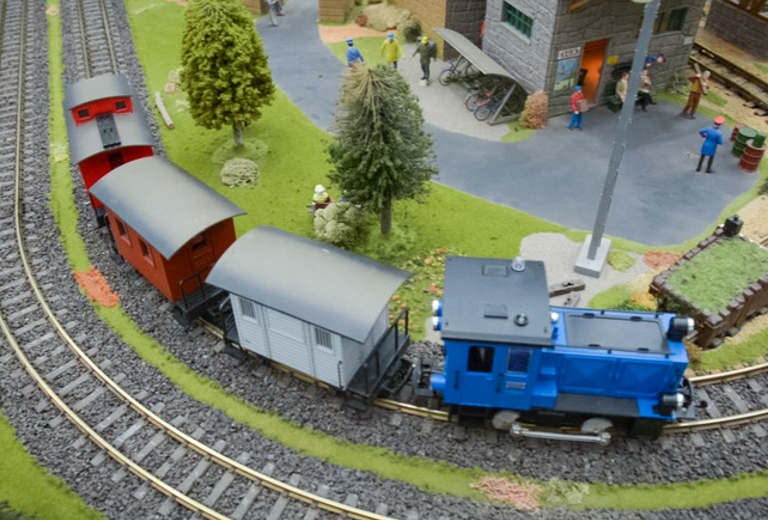
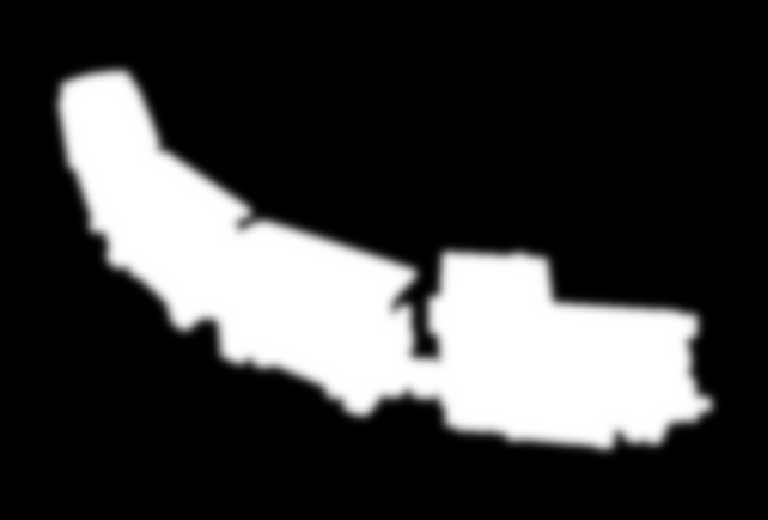

Seed: 14530641496241542329


  0%|          | 0/20 [00:00<?, ?it/s]

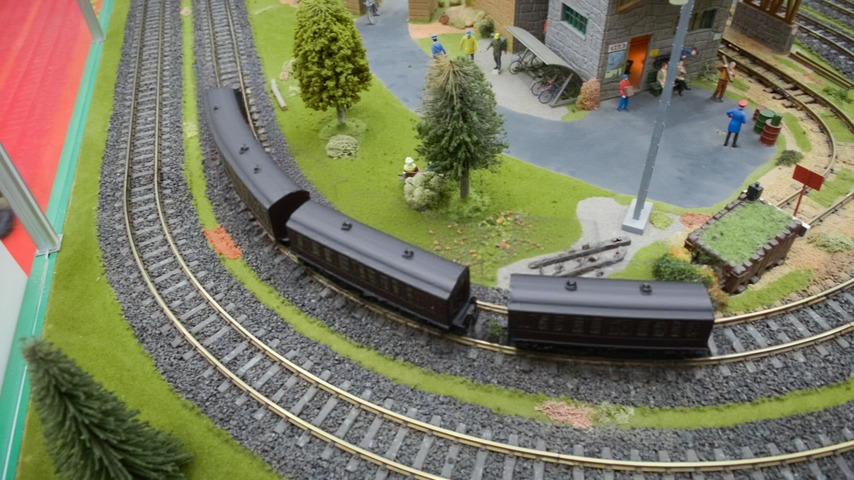

In [19]:
#@markdown <center><h1>Inpaint</h1></center>

positive_prompt = "Remove the blacked-out train and seamlessly fill the area with the surrounding scenery. The filled area should look like an empty railway track with gravel ballast, grass, and possibly a continuation of the station platform or landscape, matching the style and perspective of the miniature model. Do not generate any train cars or locomotives." # @param {"type":"string"}
negative_prompt = "watermark, text, ugly, deformed, low quality,trains" # @param {"type":"string"}
fixed_seed = 0 # @param {"type":"slider","min":0,"max":18446744073709552000,"step":1}
guidance = 30 # @param {"type":"slider","min":0,"max":50,"step":0.5}
steps = 20 # @param {"type":"slider","min":4,"max":50,"step":1}
cfg = 1 # @param {"type":"slider","min":0,"max":100,"step":0.1}
denoise = 1 # @param {"type":"slider","min":0,"max":1,"step":0.01}
use_crop_stitch = True # @param {"type":"boolean"}
mask_expand = 0 # @param {"type":"slider","min":-256,"max":256,"step":1}
mask_blur = 16 # @param {"type":"slider","min":0,"max":64,"step":0.1}
mask_blend = 16 # @param {"type":"slider","min":0,"max":32,"step":0.1}
batch_size = 1 # @param {"type":"slider","min":1,"max":20,"step":1}
sampler_name = "euler" # @param ["euler","heun","heunpp2","heunpp2","dpm_2","lms","dpmpp_2m","ipndm","deis","ddim","uni_pc","uni_pc_bh2"]
scheduler = "simple" # @param ["normal","sgm_uniform","simple","ddim_uniform"]
auto_download = False # @param {"type":"boolean"}

generate(positive_prompt, negative_prompt, fixed_seed, guidance, steps, cfg, sampler_name, scheduler, denoise, use_crop_stitch, mask_expand, mask_blur, mask_blend, batch_size, auto_download)